In [1]:
import os
import itertools
import numpy as np
import pandas as pd
import requests as rq
from tqdm.auto import tqdm

from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO, SeqIO
from Bio.Align.Applications import ClustalwCommandline

In [2]:
uniprot = pd.read_csv('seqs/csv/uniprot-filtered-reviewed_yes.tab', sep='\t', index_col=0).drop_duplicates('Sequence')
uniprot = uniprot[~uniprot['Domain [FT]'].isna()].copy()
uniprot = uniprot[uniprot['Domain [FT]'].str.lower().str.contains('upar')].copy()
uniprot

,Entry name,Protein names,Gene names,Organism,Length,Domain [FT],Sequence
Entry,,,,,,,
P0DP61,SLUR2_MACMU,Secreted Ly-6/uPAR domain-containing protein 2,SLURP2,Macaca mulatta (Rhesus macaque),97,"DOMAIN 23..95; /note=""UPAR/Ly6""",MQFHTGLLLAAVLSLQLAAAQALWCHQCTGFGGCSRGSRCPRDSTH...
P55000,SLUR1_HUMAN,Secreted Ly-6/uPAR-related protein 1 (SLURP-1)...,SLURP1 ARS,Homo sapiens (Human),103,"DOMAIN 24..73; /note=""UPAR/Ly6""",MASRWAVQLLLVAAWSMGCGEALKCYTCKEPMTSASCRTITRCKPE...
P83107,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1 (Protein BOP1),SOLD1 BOP1,Bos taurus (Bovine),100,"DOMAIN 23..100; /note=""UPAR/Ly6""; /evidence=...",MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...
P0DP57,SLUR2_HUMAN,Secreted Ly-6/uPAR domain-containing protein 2...,SLURP2,Homo sapiens (Human),97,"DOMAIN 25..95; /note=""UPAR/Ly6""; /evidence=""...",MQLGTGLLLAAVLSLQLAAAEAIWCHQCTGFGGCSHGSRCLRDSTH...
D3YWX3,PAT13_MOUSE,Prostate and testis expressed protein 13 (Pros...,Pate13 Gm3867 Pate-X,Mus musculus (Mouse),137,"DOMAIN 28..114; /note=""UPAR/Ly6""; /evidence=...",MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...
...,...,...,...,...,...,...,...
Q9GK80,UPAR_PANTR,Urokinase plasminogen activator surface recept...,PLAUR UPAR,Pan troglodytes (Chimpanzee),335,"DOMAIN 23..114; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGHPPLLPLLLLLHTCVPASWGLRCMQCKTNGDCRVEECALGQDLC...
P35456,UPAR_MOUSE,Urokinase plasminogen activator surface recept...,Plaur,Mus musculus (Mouse),327,"DOMAIN 24..117; /note=""UPAR/Ly6 1""; DOMAIN 11...",MGLPRRLLLLLLLATTCVPASQGLQCMQCESNQSCLVEECALGQDL...
P57096,PSCA_MOUSE,Prostate stem cell antigen,Psca,Mus musculus (Mouse),123,"DOMAIN 21..95; /note=""UPAR/Ly6""",MKTVFFLLLATYLALHPGAALQCYSCTAQMNNRDCLNVQNCSLDQH...


In [3]:
known_upars = set(pd.read_csv('seqs/csv/acess_upar.txt', squeeze=True)) | set(uniprot.index)
len(known_upars)

198

In [4]:
def retrieve(acess):
    """
    Retrieve protein by ID from UniProt
    """
    requestURL = f"https://www.ebi.ac.uk/proteins/api/proteins/{acess}"
#     print(requestURL)
    r = rq.get(requestURL, headers={"Accept" : "application/json"})

    if not r.ok:
        r.raise_for_status()
        return 0
    responseBody = r.json()

    try:
        features = responseBody['features']
    except KeyError:
        type_ = None
        start, end = np.nan, np.nan
    else:
        st_nd = [(start := i['begin'], end := i['end']) for i in features if i.get('description') and i['description'] == 'UPAR/Ly6']
        type_ = 'DOMAIN'
        if not st_nd:
            type_ = 'CHAIN'
            st_nd = [(start := i['begin'], end := i['end']) for i in features if i['type'] == 'CHAIN'] 

    try:
        prot_name = responseBody['protein']['submittedName'][0]['fullName']['value']

    except:
        prot_name = responseBody['protein']['recommendedName']['fullName']['value']
    
    return {'sequence': responseBody['sequence']['sequence'],
            'id': responseBody['id'],
            'protein_name': prot_name,
            'org': responseBody['organism']['names'][0]['value'],
            'start': start,
            'end': end,
            'type_': type_,
            'acess': acess}

In [5]:
res = pd.DataFrame()
for acess in tqdm(known_upars):
    tmp = retrieve(acess)
    if tmp:
        res = res.append(tmp, ignore_index=True)
    else:
        print('!!!!!!!!!!!!!!!')
        break
res = res.drop_duplicates('sequence')

short = res[res.sequence.str.len() < 190].copy()
short = short.fillna(-1)
short.start, short.end = short.start.astype(np.int32), short.end.astype(np.int32)

long = res[res.sequence.str.len() > 190].copy()

  0%|          | 0/198 [00:00<?, ?it/s]

In [6]:
res.shape[0] == res.drop_duplicates('id').shape[0]

True

In [7]:
print(long.shape, short.shape)
res

(44, 8) (153, 8)


,sequence,id,protein_name,org,start,end,type_,acess
0,MTPLLALFLVALVGLPVAQALDCHVCAYNGENCFNPMRCPAMVSYC...,LYNX1_BOVIN,Ly-6/neurotoxin-like protein 1,Bos taurus,21,105,DOMAIN,Q1RMQ4
1,MGHPLLLPLLLLLLHTGVPASWGLRCMQCNGHGNCRVEECALGQNL...,UPAR_AOTTR,Urokinase plasminogen activator surface receptor,Aotus trivirgatus,24,~,CHAIN,Q9GK77
2,MKTLLLTLVVVTIVCLDLGYTLTCVTTKSIGGVTTEDCPAGQNVCF...,3SIM2_DENAN,Muscarinic toxin 2,Dendroaspis angusticeps,22,86,CHAIN,P18328
3,MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1,Bos taurus,23,100,DOMAIN,P83107
4,MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...,PAT13_MOUSE,Prostate and testis expressed protein 13,Mus musculus,28,114,DOMAIN,D3YWX3
...,...,...,...,...,...,...,...,...
193,LECHNQQSSQPPTTKTCSGETNCYKKWWSDHRGTIIERGCGCPKVK...,3S11_NAJOX,Short neurotoxin 1,Naja oxiana,1,61,CHAIN,P01427
194,MEAAVAAPRPRLLLLVLAAAAAAAAALLPGATALQCFCHLCTKDNF...,TGFR1_HUMAN,TGF-beta receptor type-1,Homo sapiens,34,503,CHAIN,P36897
195,MKTLLLTLVVVTIVCLDLGYTIVCHTTATSPISAVTCPPGENLCYR...,3L21A_BUNMU,Alpha-bungarotoxin,Bungarus multicinctus,22,95,CHAIN,P60615
196,MNSQLVGILLSALLGVALGHRTRCYDCGGGPSNSCKQTVITCGEGE...,LY66D_MOUSE,Lymphocyte antigen 6 complex locus protein G6d,Mus musculus,22,121,DOMAIN,Q9Z1Q3


In [8]:
def get_domain(x):
    if hasattr(x, 'start'):
        n_st = x.start - 6
    else:
        n_st = 0
    n_end = len(x.sequence)
    result = []
    for st, en in itertools.product(np.arange(n_st, n_end - 20), np.arange(n_st + 20, n_end + 1)):
        if len((string := x.sequence[st: en])) > 45:
            if 'CN' == string[-2:] and string[2] == 'C' and string.count('C') % 2 == 0 and string.count('C') >= 8 and string.count('C') <= 12 and len(string) < 100:
                result.append(string)
            
    return max(result, key=lambda x: len(x)) if result else np.nan

In [9]:
short['domain'] = short.apply(get_domain, axis=1)
short = short.drop_duplicates('sequence')
inds = short[short.domain.isna()].index
print(inds)
for i in inds:
    short.loc[i, 'domain'] = short.loc[i, 'sequence'][short.loc[i, 'start']: short.loc[i, 'end']]
short

Int64Index([87], dtype='int64')


,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MTPLLALFLVALVGLPVAQALDCHVCAYNGENCFNPMRCPAMVSYC...,LYNX1_BOVIN,Ly-6/neurotoxin-like protein 1,Bos taurus,21,105,DOMAIN,Q1RMQ4,LDCHVCAYNGENCFNPMRCPAMVSYCMTTRTYYTPTRMKVSKSCVP...
2,MKTLLLTLVVVTIVCLDLGYTLTCVTTKSIGGVTTEDCPAGQNVCF...,3SIM2_DENAN,Muscarinic toxin 2,Dendroaspis angusticeps,22,86,CHAIN,P18328,LTCVTTKSIGGVTTEDCPAGQNVCFKRWHYVTPKNYDIIKGCAATC...
3,MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...,SOLD1_BOVIN,Secreted protein of Ly-6 domain 1,Bos taurus,23,100,DOMAIN,P83107,LECFQCNRVNASGVCETGGSTCQTQGSQQCFLRRIFENGTLSYGHQ...
4,MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...,PAT13_MOUSE,Prostate and testis expressed protein 13,Mus musculus,28,114,DOMAIN,D3YWX3,RHCNLCSHYDGFKCRNGMKSCWKFDLWTQNRTCTTENYYYYDRFTG...
5,MKHLLLLTLSALLYCWVSADTRCHSCYKVPVLGCVDRQSCRLEPGH...,LY66C_MOUSE,Lymphocyte antigen 6 complex locus protein G6c,Mus musculus,21,112,DOMAIN,Q9Z1Q4,TRCHSCYKVPVLGCVDRQSCRLEPGHKCLTTNVYLGKMWVFSNLRC...
...,...,...,...,...,...,...,...,...,...
192,MRGTRLALLALVLAACGELAPALRCYVCPEPTGVSDCVTIATCTTN...,LYPD2_HUMAN,Ly6/PLAUR domain-containing protein 2,Homo sapiens,25,100,DOMAIN,Q6UXB3,LRCYVCPEPTGVSDCVTIATCTTNETMCKTTLYSREIVYPFQGDST...
193,LECHNQQSSQPPTTKTCSGETNCYKKWWSDHRGTIIERGCGCPKVK...,3S11_NAJOX,Short neurotoxin 1,Naja oxiana,1,61,CHAIN,P01427,LECHNQQSSQPPTTKTCSGETNCYKKWWSDHRGTIIERGCGCPKVK...
195,MKTLLLTLVVVTIVCLDLGYTIVCHTTATSPISAVTCPPGENLCYR...,3L21A_BUNMU,Alpha-bungarotoxin,Bungarus multicinctus,22,95,CHAIN,P60615,IVCHTTATSPISAVTCPPGENLCYRKMWCDAFCSSRGKVVELGCAA...
196,MNSQLVGILLSALLGVALGHRTRCYDCGGGPSNSCKQTVITCGEGE...,LY66D_MOUSE,Lymphocyte antigen 6 complex locus protein G6d,Mus musculus,22,121,DOMAIN,Q9Z1Q3,TRCYDCGGGPSNSCKQTVITCGEGERCGFLDRKPQPSSEQAKQPSA...


In [10]:
short.id = short.id.str.split('_').str[0] + '_|_' + short.org.str.replace(' ', '_')
short

,sequence,id,protein_name,org,start,end,type_,acess,domain
0,MTPLLALFLVALVGLPVAQALDCHVCAYNGENCFNPMRCPAMVSYC...,LYNX1_|_Bos_taurus,Ly-6/neurotoxin-like protein 1,Bos taurus,21,105,DOMAIN,Q1RMQ4,LDCHVCAYNGENCFNPMRCPAMVSYCMTTRTYYTPTRMKVSKSCVP...
2,MKTLLLTLVVVTIVCLDLGYTLTCVTTKSIGGVTTEDCPAGQNVCF...,3SIM2_|_Dendroaspis_angusticeps,Muscarinic toxin 2,Dendroaspis angusticeps,22,86,CHAIN,P18328,LTCVTTKSIGGVTTEDCPAGQNVCFKRWHYVTPKNYDIIKGCAATC...
3,MAKCLLLLLLVVLSSLLGLPQALECFQCNRVNASGVCETGGSTCQT...,SOLD1_|_Bos_taurus,Secreted protein of Ly-6 domain 1,Bos taurus,23,100,DOMAIN,P83107,LECFQCNRVNASGVCETGGSTCQTQGSQQCFLRRIFENGTLSYGHQ...
4,MFQKLLLSVFIILLMDVGERVLTFNLLRHCNLCSHYDGFKCRNGMK...,PAT13_|_Mus_musculus,Prostate and testis expressed protein 13,Mus musculus,28,114,DOMAIN,D3YWX3,RHCNLCSHYDGFKCRNGMKSCWKFDLWTQNRTCTTENYYYYDRFTG...
5,MKHLLLLTLSALLYCWVSADTRCHSCYKVPVLGCVDRQSCRLEPGH...,LY66C_|_Mus_musculus,Lymphocyte antigen 6 complex locus protein G6c,Mus musculus,21,112,DOMAIN,Q9Z1Q4,TRCHSCYKVPVLGCVDRQSCRLEPGHKCLTTNVYLGKMWVFSNLRC...
...,...,...,...,...,...,...,...,...,...
192,MRGTRLALLALVLAACGELAPALRCYVCPEPTGVSDCVTIATCTTN...,LYPD2_|_Homo_sapiens,Ly6/PLAUR domain-containing protein 2,Homo sapiens,25,100,DOMAIN,Q6UXB3,LRCYVCPEPTGVSDCVTIATCTTNETMCKTTLYSREIVYPFQGDST...
193,LECHNQQSSQPPTTKTCSGETNCYKKWWSDHRGTIIERGCGCPKVK...,3S11_|_Naja_oxiana,Short neurotoxin 1,Naja oxiana,1,61,CHAIN,P01427,LECHNQQSSQPPTTKTCSGETNCYKKWWSDHRGTIIERGCGCPKVK...
195,MKTLLLTLVVVTIVCLDLGYTIVCHTTATSPISAVTCPPGENLCYR...,3L21A_|_Bungarus_multicinctus,Alpha-bungarotoxin,Bungarus multicinctus,22,95,CHAIN,P60615,IVCHTTATSPISAVTCPPGENLCYRKMWCDAFCSSRGKVVELGCAA...
196,MNSQLVGILLSALLGVALGHRTRCYDCGGGPSNSCKQTVITCGEGE...,LY66D_|_Mus_musculus,Lymphocyte antigen 6 complex locus protein G6d,Mus musculus,22,121,DOMAIN,Q9Z1Q3,TRCYDCGGGPSNSCKQTVITCGEGERCGFLDRKPQPSSEQAKQPSA...


In [11]:
def save_df_to_fasta(df, filename, seq_col='sequence', org='org', protein_name='protein_name'):
    req_list = []
    for ind, row in df.iterrows():
        req_list.append(SeqRecord(seq=Seq(row[seq_col]),
                                  id=row.id,
                                  name=row[protein_name],
                                  description='| ' + row[protein_name] + ' | ' + row[org]
                                 ))
    with open(filename, 'w') as f:
        SeqIO.write(req_list, f, 'fasta')

In [12]:
save_df_to_fasta(short, 'blast/blastdb/short_ly_domain_db.fs', seq_col='domain')

In [13]:
%%bash -s 'short_ly_domain_db.fs'
cd 'blast/blastdb/'
makeblastdb -in "$1" -dbtype prot



Building a new DB, current time: 11/18/2021 17:07:02
New DB name:   /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
New DB title:  short_ly_domain_db.fs
Sequence type: Protein
Deleted existing Protein BLAST database named /home/user503/python/Filogenetics/blast/blastdb/short_ly_domain_db.fs
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 153 sequences in 0.00376296 seconds.


In [14]:
%%bash -s 'blastdb/short_ly_domain_db.fs' 'aplanci_blast_short.txt' 'arubens_blast_short.txt'
cd 'blast'
blastp -db "$1" -query "../seqs/aplanci_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$2"
blastp -db "$1" -query "../seqs/arubens_seq.fasta" -outfmt 6 -evalue 1e-5 -num_threads 4 -out "$3"
ls

aplanci_blast_short.txt
arubens_blast_short.txt
blastdb


In [15]:
def read_blast(name, org):
    df = pd.read_csv(f'seqs/csv/{name}', index_col=0)
    bl_name = name.split('_', 1)[0]
    bl = pd.read_csv(f'blast/{bl_name}_blast_short.txt', index_col=0, sep='\t', header=None).index.unique().tolist()
    df = df.loc[bl].reset_index()
    df['org'] = org
    df['genes'] = df.genes + '_|_' + df.org.str.replace(' ', '_')
    df['domain'] = df.apply(get_domain, axis=1)
    return df[df.sequence.str.len() < 190].drop_duplicates().set_index('genes')

In [16]:
aru = read_blast('arubens_seq.csv', 'Asterias rubens')
apl = read_blast('aplanci_seq.csv', 'Acanthaster planci')
print(aru.shape[0], apl.shape[0])

5 3


In [17]:
aru

,sequence,gene_len,org,domain
genes,,,,
XP_033628517.1_|_Asterias_rubens,MRIKMVFKFRRNSEGIFCILMTLMIILMAVCFRTASSLQCFTCEAE...,155,Asterias rubens,LQCFTCEAEDTNENCNIKEAPVLKTCTSRQDRCLTQVIYSTERGKL...
XP_033638913.1_|_Asterias_rubens,MNTLATIVVLMSLIAGMSALTCNTCGWITGVSDESCLDEFDATASN...,126,Asterias rubens,LTCNTCGWITGVSDESCLDEFDATASNSSVTCASGYDMCSKSTTKV...
XP_033640057.1_|_Asterias_rubens,MLLSWPLGIKQWLSPVLFYVVLMSTCSAPTEPTLIFSYDDSTPFPN...,178,Asterias rubens,IKCFTCTDKKSNRECNERAYDAFCPKGTKYCYSSHYLNQKSGESIL...
XP_033640058.1_|_Asterias_rubens,MLLSWPLGIKQWLSPVLFYVVLMSTCSAPTEPTLIFSYDDSTPFPN...,178,Asterias rubens,IKCFTCTDKKSNRECNERAYDAFCPKGTKYCYSSHYLNQKSGESIL...
XP_033644501.1_|_Asterias_rubens,METNPSSQRLVVWMFIFAATIYFAQGNLRCYDCDVDFKTMSNPDLN...,152,Asterias rubens,LRCYDCDVDFKTMSNPDLNCIHNVINSTGDVMYEPRDCQPHERFCK...


In [18]:
apl

,sequence,gene_len,org,domain
genes,,,,
XP_022086630.1_|_Acanthaster_planci,MKMHPINLIFSLVGNVVGLECFDCVDGVSPALDTVACADLFNRTTT...,135,Acanthaster planci,LECFDCVDGVSPALDTVACADLFNRTTTDSRVNRRPCPAGFDACAK...
XP_022094712.1_|_Acanthaster_planci,MWCSMLDLFIASLLICIHTVYSLQCYTCAAEDTNENCKINEAPVLR...,137,Acanthaster planci,LQCYTCAAEDTNENCKINEAPVLRTCPSTEDRCLTQVIYSTERGKL...
XP_022100632.1_|_Acanthaster_planci,MKLLLIAGILLASVGSLSAAECYLCSYVPSAMGEECKDPFNSSNNS...,124,Acanthaster planci,AECYLCSYVPSAMGEECKDPFNSSNNSTETCEGTYCLKVVSKISGE...


In [19]:
df = pd.concat([short.set_index('id'), apl]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_apl_short_upar.fasta', seq_col='domain')

In [20]:
df = pd.concat([short.set_index('id'), aru]).fillna('').reset_index().rename(columns={'index': 'id'})
save_df_to_fasta(df, 'seqs/blast_aru_short_upar.fasta', seq_col='domain')

In [21]:
def align(in_, out):
    fasta, align = in_, out

    cmd = ClustalwCommandline('clustalw', infile=fasta, align=True,
                              matrix='matrix.txt', pwmatrix='matrix.txt',
                              type='PROTEIN', outfile=align, quiet=False)
    x = cmd()
    for i in x:
        print(i)
    
    os.rename(fasta.rsplit('.', 1)[0] + '.dnd',
              align.rsplit('.', 1)[0] + '.dnd')

In [22]:
align('seqs/blast_aru_short_upar.fasta', 'result/aln/blast_aru_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein
Sequence format is Pearson
Sequence 1: LYNX1_|_Bos_taurus                             72 aa
Sequence 2: 3SIM2_|_Dendroaspis_angusticeps                64 aa
Sequence 3: SOLD1_|_Bos_taurus                             76 aa
Sequence 4: PAT13_|_Mus_musculus                           85 aa
Sequence 5: LY66C_|_Mus_musculus                           79 aa
Sequence 6: LY65C_|_Canis_lupus_familiaris                 82 aa
Sequence 7: LYPD1_|_Rattus_norvegicus                      85 aa
Sequence 8: LY6E_|_Homo_sapiens                            79 aa
Sequence 9: GML_|_Homo_sapiens                             80 aa
Sequence 10: SLUR1_|_Homo_sapiens                           78 aa
Sequence 11: 3SA8_|_Naja_kaouthia                           60 aa
Sequence 12: LY6I_|_Mus_musculus                            79 aa
Sequence 13: B8Y6H3_|_Schistosoma_mansoni                   72 aa
Sequence 14: A0A0F6QDT3_|_Aneides_lug

In [23]:
align('seqs/blast_apl_short_upar.fasta', 'result/aln/blast_apl_short_align.aln')




 CLUSTAL 2.1 Multiple Sequence Alignments


Sequence type explicitly set to Protein
Sequence format is Pearson
Sequence 1: LYNX1_|_Bos_taurus                             72 aa
Sequence 2: 3SIM2_|_Dendroaspis_angusticeps                64 aa
Sequence 3: SOLD1_|_Bos_taurus                             76 aa
Sequence 4: PAT13_|_Mus_musculus                           85 aa
Sequence 5: LY66C_|_Mus_musculus                           79 aa
Sequence 6: LY65C_|_Canis_lupus_familiaris                 82 aa
Sequence 7: LYPD1_|_Rattus_norvegicus                      85 aa
Sequence 8: LY6E_|_Homo_sapiens                            79 aa
Sequence 9: GML_|_Homo_sapiens                             80 aa
Sequence 10: SLUR1_|_Homo_sapiens                           78 aa
Sequence 11: 3SA8_|_Naja_kaouthia                           60 aa
Sequence 12: LY6I_|_Mus_musculus                            79 aa
Sequence 13: B8Y6H3_|_Schistosoma_mansoni                   72 aa
Sequence 14: A0A0F6QDT3_|_Aneides_lug

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-poster')

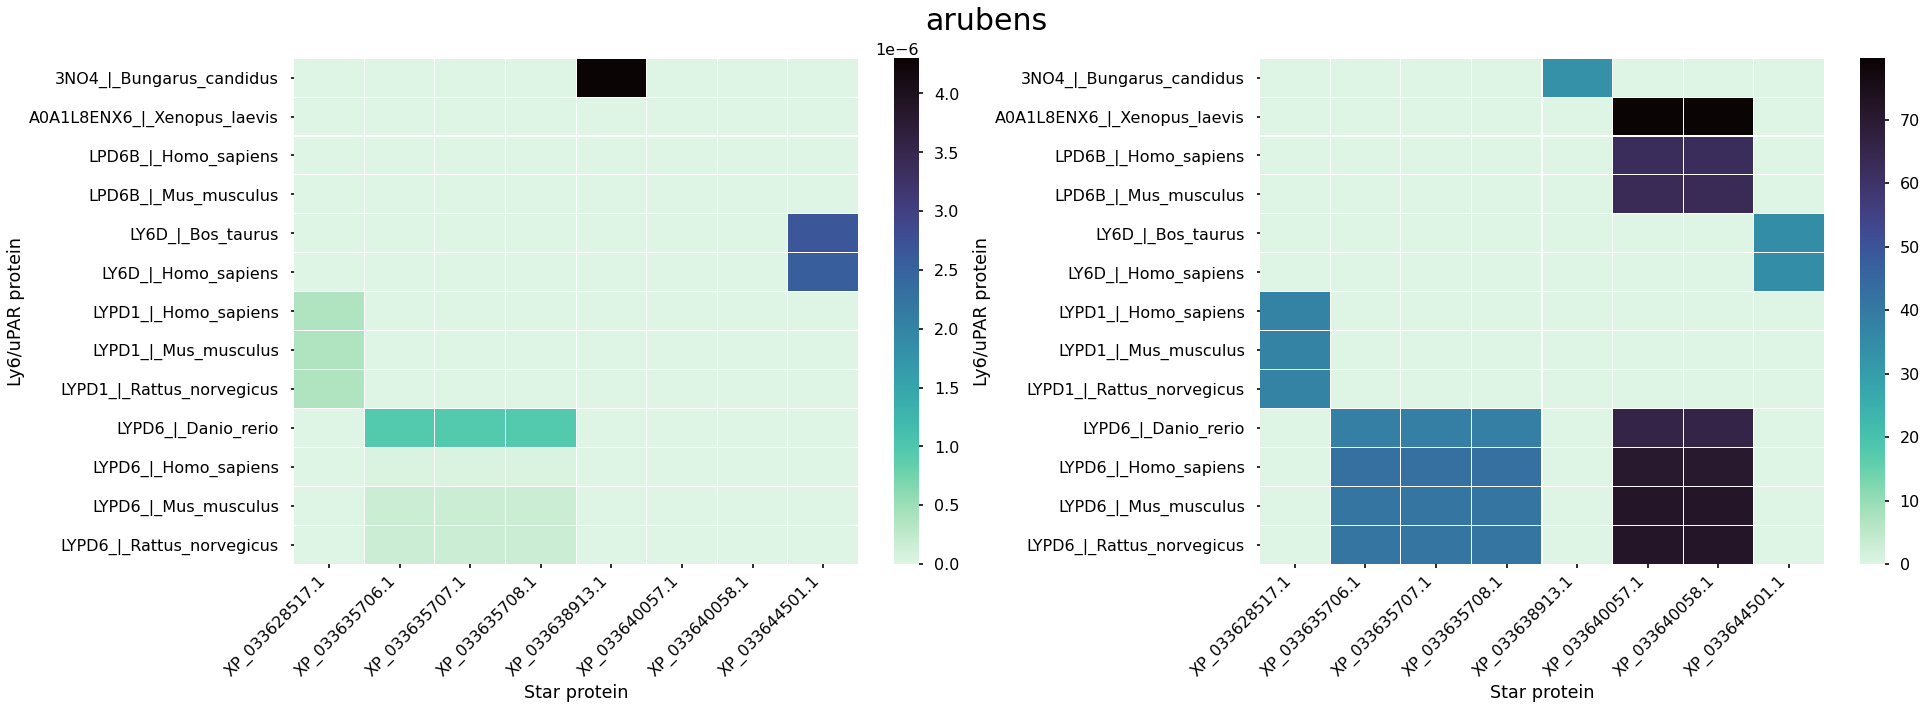

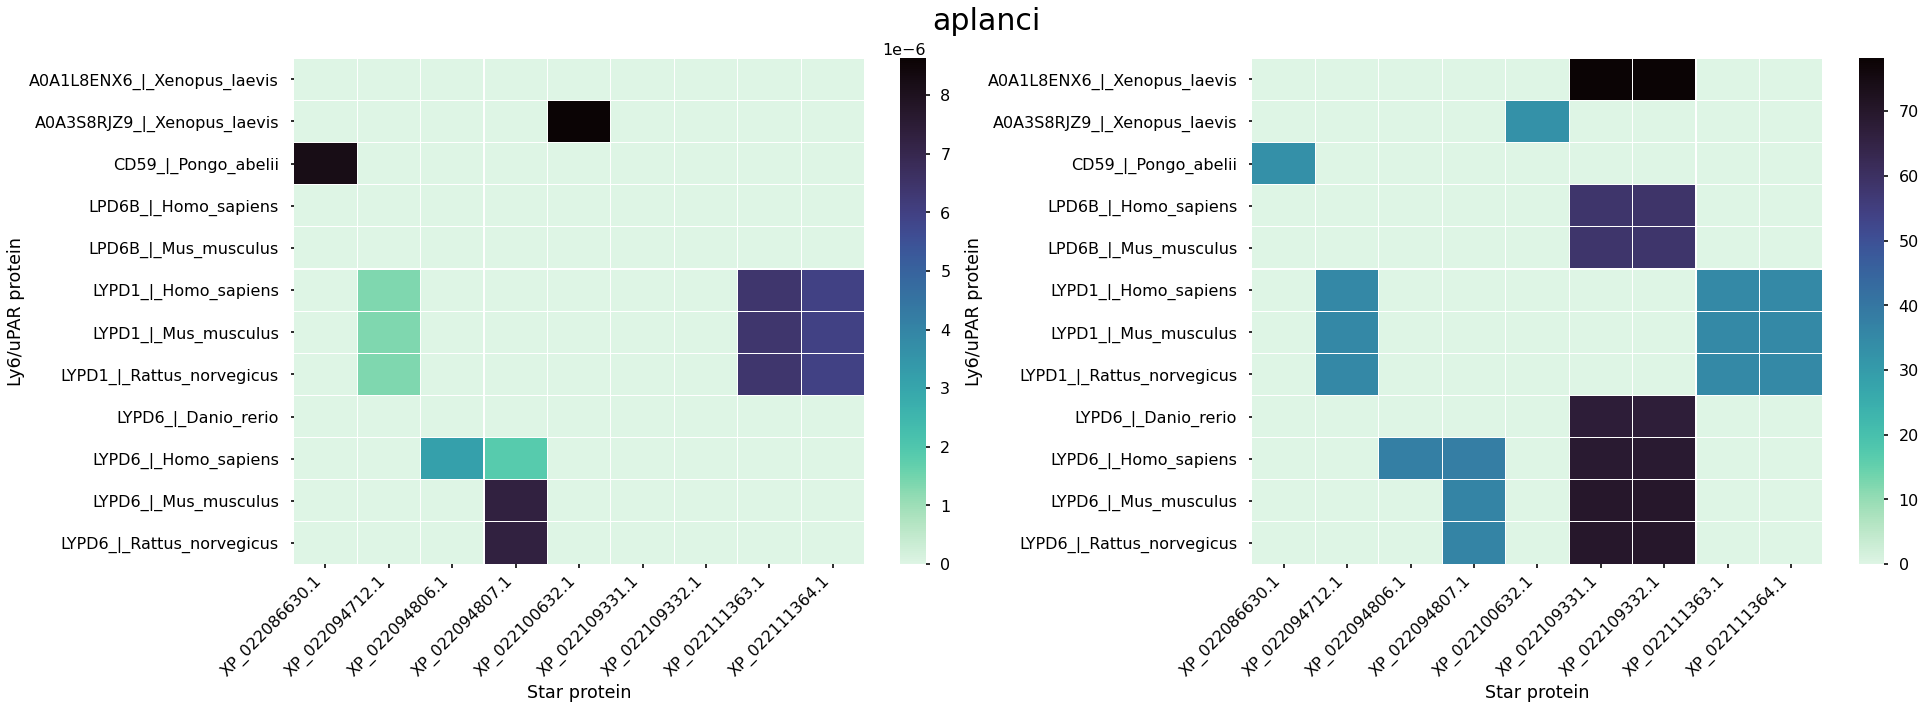

In [25]:
def print_heatmap(path):
    sp = 'Star protein'
    lp = 'Ly6/uPAR protein'
    ev = 'e-value'
    bs = 'bit score'
    df = pd.read_csv(path, sep='\t', header=None).rename(columns={
        0: sp,
        1: lp,
        10: ev,
        11: bs
    })
    kwargs = {'cmap': 'mako_r', 'linecolor': 'white', "linewidths": 0.1}
    fig, ax = plt.subplots(1, 2, figsize=(27.5, 10))
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=ev).fillna(0), ax=ax[0], **kwargs)
    sns.heatmap(data=df.pivot(index=lp, columns=sp, values=bs).fillna(0), ax=ax[1], **kwargs)
    for i in ax:
        i.set_xticklabels(i.get_xticklabels(), rotation = 45, ha="right", va='center_baseline')
    fig.suptitle(os.path.split(path)[-1].split('_')[0], fontsize=30)
    plt.tight_layout()
    plt.savefig(f"result/img/{path.split('/')[-1].rsplit('.', 1)[0]}.svg", facecolor='white', format='svg')
    plt.show()
print_heatmap('blast/arubens_blast_short.txt')
print_heatmap('blast/aplanci_blast_short.txt')